## 1. Libraries and helpers

In [13]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
from collections import Counter
import re


In [36]:
def get_top_words_per_cluster(cluster, n_words=20):
    # Filter the dataframe for the given cluster
    cluster_df = analysis_df[analysis_df['cluster'] == cluster]
    
    # Get all the words in the cluster
    all_words = [word for words in cluster_df['intervention_words'] for word in words]
    
    # Count the frequency of each word
    word_counts = Counter(all_words)
    
    # Get the top n_words
    top_words = word_counts.most_common(n_words)
    
    return top_words

## 2. Preprocessing datasets

In [4]:
clusters = pd.read_csv(r"C:\Users\asarr\Documents\MACSS\Thesis\results\sample_clusters.csv")
clusters.columns

Index(['intervention_id', 'embeddings_str', 'embeddings', 'cluster'], dtype='object')

In [10]:
clusters = clusters[['intervention_id', 'embeddings', 'cluster']]

In [11]:
sessions = pd.read_csv(r"C:\Users\asarr\Documents\MACSS\Thesis\results\gacetas_info.csv")
sessions.columns = ['session_id', 'date', 'chamber']
sessions.head()

,session_id,date,chamber
0,gaceta_2055,27/11/2024,senate
1,gaceta_2054,27/11/2024,senate
2,gaceta_2051,27/11/2024,senate
3,gaceta_2050,27/11/2024,house
4,gaceta_2049,26/11/2024,senate


In [12]:
ints = pd.read_csv(r"C:\Users\asarr\Documents\MACSS\Thesis\results\interventions_sample.csv", index_col=0)
ints = ints[['session_id', 'intervention_id', 'intervention_text', 'intervention_words']]

In [13]:
full_df = pd.merge(clusters, ints, on='intervention_id', how='inner')

In [14]:
full_df = pd.merge(full_df, sessions, on='session_id', how='inner')

In [39]:
full_df = pd.read_csv(r"C:\Users\asarr\Documents\MACSS\Thesis\results\full_df.csv", index_col=0)
full_df['intervention_words'] = full_df['intervention_words'].apply(ast.literal_eval)
full_df.head()

,session_id,date,chamber,intervention_id,intervention_text,intervention_words,embeddings,cluster,num_words,year,svd_embeddings,graph_embeddings
0,gaceta_459 (7),2006-10-18,senate,452004,(julio 21) por medio de la cual se crea una c...,"[accidental, acreditación, acrediten, artículo...",[ 2.75705218e-01 -1.56717077e-01 5.24776168e-...,5,21,2006,[-1.07373972e+01 -5.24858566e-02 -3.47477753e-...,[-10.73739721 -0.05248475]
1,gaceta_459 (7),2006-10-18,senate,452003,(septiembre 11) por medio de la cual se aclar...,"[aclara, aclárese, acto, administrativo, artíc...",[ 4.02346551e-01 -1.51027605e-01 2.49001503e-...,1,26,2006,[-1.11914571e+01 1.63042020e+00 1.67238361e+...,[-11.19145712 1.63042081]
2,gaceta_459 (7),2006-10-18,senate,452002,(septiembre 8) por medio de la cual se design...,"[artículo, comisión, congreso, convenio, desig...",[ 1.86938807e-01 -1.24048591e-01 4.23117690e-...,5,16,2006,[-1.12215688e+01 -2.87521366e-01 -6.22032624e-...,[-11.22156882 -0.2875204 ]
3,gaceta_459 (7),2006-10-18,senate,452001,si bien el crecimiento económico es un factor ...,"[aumentado, crecimiento, distribución, economí...",[ 5.93414120e-02 -1.13201797e-01 1.75440997e-...,5,21,2006,[-1.10547869e+01 -2.22703892e+00 -2.72106466e+...,[-11.05478689 -2.22703888]
4,gaceta_459 (7),2006-10-18,senate,451999,fuente: merpd la disminución en la inequidad ...,"[aquellos, aumentado, caído, coeficiente, conc...",[ 4.15660948e-01 -1.86677556e-02 3.19064856e-...,2,33,2006,[-1.08555325e+01 -1.99172156e+00 -1.98372695e+...,[-10.85553251 -1.99172263]


In [16]:
full_df = full_df[['session_id', 'date', 'chamber', 'intervention_id', 'intervention_text', 'intervention_words', 'embeddings', 'cluster']]

In [33]:
full_df['embeddings'] = full_df['embeddings'].apply(lambda x: np.array(ast.literal_eval(x)))
full_df['intervention_words'] = full_df['intervention_words'].apply(lambda x: ast.literal_eval(x))
full_df['num_words'] = full_df['intervention_words'].apply(lambda x: len(x))

In [18]:
full_df['date'] = pd.to_datetime(full_df['date'])

C:\Users\asarr\AppData\Local\Temp\ipykernel_76748\3237865655.py:1: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  full_df['date'] = pd.to_datetime(full_df['date'])


In [19]:
full_df['year'] = full_df['date'].apply(lambda x: x.year)

In [21]:
embeddings_arrays = np.vstack(full_df['embeddings'].values)
svd_embeddings = TruncatedSVD(n_components=172).fit_transform(embeddings_arrays)
graph_embeddings = TruncatedSVD(n_components=2).fit_transform(embeddings_arrays)
full_df['svd_embeddings'] = list(svd_embeddings)
full_df['graph_embeddings'] = list(graph_embeddings)

In [22]:
full_df.to_csv(r"C:\Users\asarr\Documents\MACSS\Thesis\results\full_df.csv")

## 3. Initial viz

In [42]:
#only using useful clusters
useful_clusters = [1, 2, 3, 6, 7, 9]

analysis_df = full_df[full_df['cluster'].isin(useful_clusters)]

<Axes: >

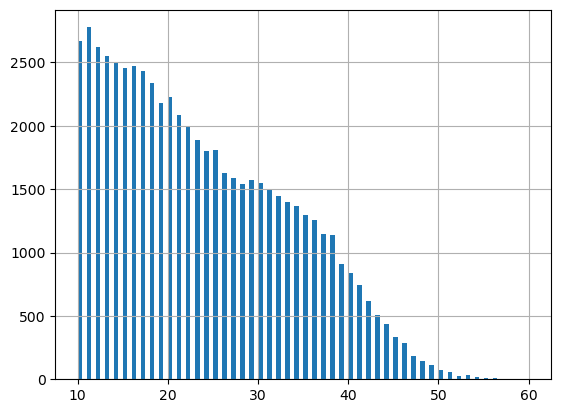

In [8]:
#length historgram
analysis_df['num_words'].hist(bins=100)

In [9]:
#distribution of lengths by cluster
analysis_df.groupby('cluster')['num_words'].describe()

,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
1,15144.0,25.633980,9.919508,10.0,17.0,25.0,33.0,60.0
2,6143.0,24.573336,9.622682,10.0,17.0,23.0,32.0,59.0
3,12507.0,22.007196,8.978898,10.0,14.0,20.0,28.0,55.0
6,7917.0,16.228875,6.065681,10.0,12.0,14.0,19.0,54.0
7,14611.0,26.609883,9.797073,10.0,18.0,25.0,35.0,59.0
9,4218.0,23.555951,9.630982,10.0,15.0,22.0,31.0,56.0


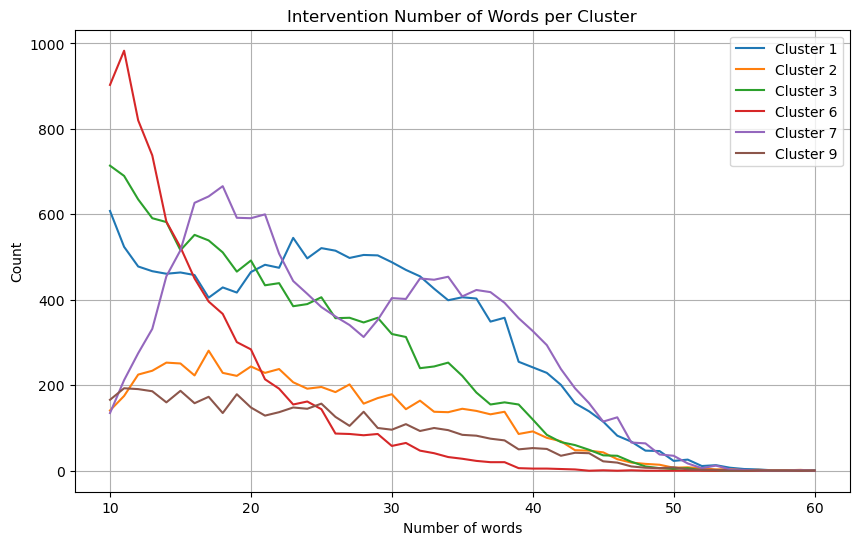

In [10]:
length_cluster_counts = analysis_df.groupby(['num_words', 'cluster']).size().unstack(fill_value=0)
plt.figure(figsize=(10, 6))
for cluster in length_cluster_counts.columns:
    plt.plot(length_cluster_counts.index, length_cluster_counts[cluster], label=f"Cluster {cluster}")

plt.xlabel("Number of words")
plt.ylabel("Count")
plt.title("Intervention Number of Words per Cluster")
plt.legend()
plt.grid(True)
plt.show()


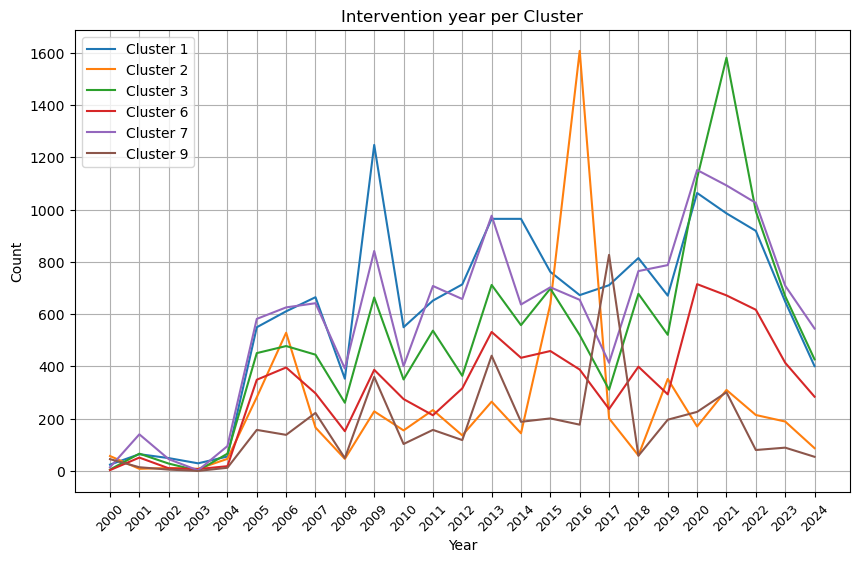

In [11]:
length_cluster_counts = analysis_df.groupby(['year', 'cluster']).size().unstack(fill_value=0)
plt.figure(figsize=(10, 6))
for cluster in length_cluster_counts.columns:
    plt.plot(length_cluster_counts.index, length_cluster_counts[cluster], label=f"Cluster {cluster}")

plt.xlabel("Year")
plt.ylabel("Count")
plt.title("Intervention year per Cluster")
plt.legend()
plt.xticks(ticks=sorted(full_df['year'].unique()), labels=sorted(full_df['year'].unique()), fontsize=9, rotation=45)
plt.grid(True)
plt.show()

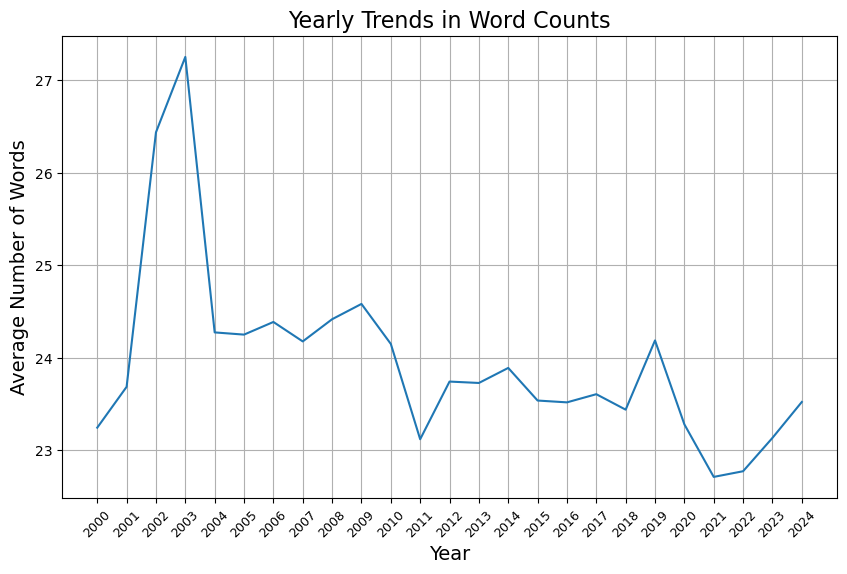

In [15]:
import matplotlib.pyplot as plt
import pandas as pd

# Group by year and calculate the average number of words
yearly_trends = analysis_df.groupby('year')['num_words'].mean().reset_index()

# Plot
plt.figure(figsize=(10, 6))
plt.plot(yearly_trends['year'], yearly_trends['num_words'])
plt.title('Yearly Trends in Word Counts', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Average Number of Words', fontsize=14)
plt.xticks(ticks=sorted(full_df['year'].unique()), labels=sorted(full_df['year'].unique()), fontsize=9, rotation=45)
plt.grid(True)
plt.show()

In [22]:
analysis_df['graph_embeddings'].iloc[0]


'[-11.19145712   1.63042081]'

In [ ]:
pattern = r"-?\d*\.\d+"
# analysis_df['graph_embeddings'] = analysis_df['graph_embeddings'].apply(lambda x: [float(i) for i in re.findall(pattern, x)])

analysis_df[['embedding_1', 'embedding_2']] = pd.DataFrame(analysis_df['graph_embeddings'].tolist(), index=analysis_df.index)

In [23]:
analysis_df['embedding_1'].describe()

count    60540.000000
mean       -11.643275
std          0.924718
min        -13.675831
25%        -12.137491
50%        -11.754134
75%        -11.331237
max         -1.010562
Name: embedding_1, dtype: float64

In [22]:
analysis_df.query('embedding_1 > -2')

,session_id,date,chamber,intervention_id,intervention_text,intervention_words,embeddings,cluster,num_words,year,svd_embeddings,graph_embeddings,embedding_1,embedding_2
594,gaceta_1536,2020-12-21,house,451094,para garantizar el pago de los salarios de los...,"['bien', 'cargo', 'comisarias', 'demás', 'dist...",[ 1.79845423e-01 -4.32056099e-01 6.28599167e-...,9,25,2020,[-1.14753677e+01 -4.95945791e-04 -9.31775662e-...,"[-1.14753677, -4.96393704]",-1.147537,-4.963937
622,gaceta_1536,2020-12-21,house,451049,manifestación del principio de separación de p...,"['debido', 'derecho', 'función', 'jurisdiccion...",[ 8.72913361e-01 -2.83375144e-01 -1.57788754e-...,9,10,2020,[-1.02830096e+01 6.25661540e-03 3.80261128e-...,"[-1.02830096, 6.25819032]",-1.028301,6.258190
636,gaceta_1536,2020-12-21,house,451027,. igualmente convención interamericana sobre l...,"['artículo', 'autoridad', 'autónoma', 'autónom...",[ 4.43535239e-01 -2.56414682e-01 4.16347861e-...,9,35,2020,[-1.14380555e+01 1.05504613e-02 -1.16944799e-...,"[-1.14380555, 1.05512455]",-1.143806,1.055125
823,gaceta_633 (1),2022-06-06,senate,450738,"señor secretario, esperemos 10 minuticos para ...","['compañero', 'consideración', 'constituya', '...",[ 6.50097370e-01 -1.45688355e-01 -4.59787518e-...,6,13,2022,[-1.20293771e+01 -2.52814562e-03 3.08032072e+...,"[-1.20293771, -2.52658492]",-1.202938,-2.526585
1068,gaceta_29 (2),2019-02-06,house,450372,descripción de la limitación del aplicativo si...,"['adquirir', 'artículo', 'cgn', 'comple', 'com...",[ 1.80979460e-01 -3.82757425e-01 6.30388916e-...,9,28,2019,[-1.05926134e+01 -3.66658340e-03 2.02549355e-...,"[-1.05926134, -3.66619057]",-1.059261,-3.666191
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85130,gaceta_998 (2),2015-12-01,senate,299926,millones de pesos programas recursos apoyo ...,"['agropecuario', 'anctia', 'anexo', 'anualment...",[ 7.05476524e-03 -3.70407701e-01 5.02924204e-...,2,27,2015,[-1.15147618e+01 5.58696900e-03 -1.34567112e+...,"[-1.15147618, 5.5864127]",-1.151476,5.586413
85299,gaceta_998 (2),2015-12-01,senate,299733,6t]taprx ]st8]vatb^b _pap[p?^q[prx ]ada...,"['atención', 'buena', 'capacitación', 'culpa',...",[ 1.58766791e-01 -3.15657437e-01 5.85550487e-...,2,25,2015,[-1.13872865e+01 3.41931452e-04 -2.03832055e+...,"[-1.13872865, 3.4225925]",-1.138729,3.422592
85973,gaceta_1069,2019-10-30,senate,298719,para obtener la aprobación del certificado de...,"['acompaña', 'allegada', 'ambientales', 'ambie...",[-2.84035560e-02 -6.24051332e-01 3.03948939e-...,2,44,2019,[-1.07615117e+01 -4.59461687e-03 -2.35140953e-...,"[-1.07615117, -4.5946862]",-1.076151,-4.594686
87473,gaceta_268 (1),2022-04-06,house,295959,¿falta algún representante por votar? se cierr...,"['algún', 'cierra', 'electrónicos', 'falta', '...",[-1.45090401e-01 -3.16583514e-01 9.07805786e-...,6,12,2022,[-1.13222779e+01 9.14579585e-03 2.70767976e+...,"[-1.13222779, 9.14417516]",-1.132228,9.144175


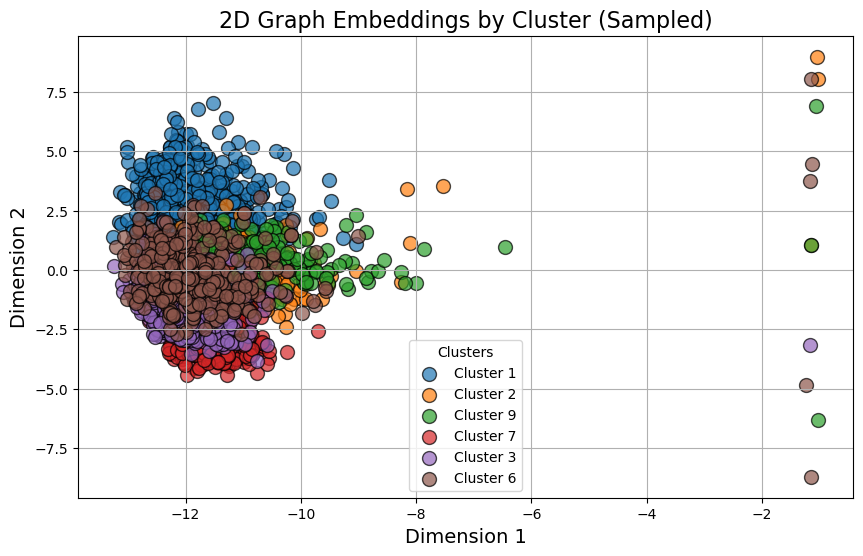

In [28]:
# Set a sample size (for example, 10% of the data)
sample_size = 0.05

# Create a scatter plot
plt.figure(figsize=(10, 6))

# Loop through unique clusters to plot each one with a distinct color and black outline
clusters = analysis_df['cluster'].unique()
for cluster in clusters:
    # Get the data for the current cluster
    cluster_data = analysis_df[analysis_df['cluster'] == cluster]
    
    # Sample the data from this cluster (e.g., 10% of the data)
    sample_data = cluster_data.sample(frac=sample_size, random_state=42)
    
    # Plot the sampled data
    plt.scatter(sample_data['embedding_1'], sample_data['embedding_2'], 
                label=f'Cluster {cluster}', 
                alpha=0.7, edgecolor='black', s=100)

# Add a legend
plt.legend(title="Clusters")

# Add labels and title
plt.xlabel('Dimension 1', fontsize=14)
plt.ylabel('Dimension 2', fontsize=14)
plt.title('2D Graph Embeddings by Cluster (Sampled)', fontsize=16)
plt.grid(True)

# Show the plot
plt.show()

In [45]:
import warnings
warnings.filterwarnings('ignore')

esp_stopwords = [
    "a", "al", "algo", "algunas", "algunos", "ante", "antes", "aquel", "aquella",
    "aquellas", "aquellos", "aquí", "cada", "casi", "como", "con", "contra",
    "cual", "cuales", "cuando", "cuanta", "cuantas", "cuanto", "cuantos", "de",
    "del", "dentro", "donde", "dos", "el", "él", "ella", "ellas", "ellos", "en",
    "entre", "esa", "esas", "ese", "eso", "esos", "esta", "estas", "este",
    "estos", "lo", "los", "la", "las", "me", "mi", "mí", "mis", "nos", "nosotras",
    "nosotros", "o", "otra", "otras", "otro", "otros", "para", "pero", "poco",
    "por", "que", "qué", "se", "sí", "sin", "sobre", "su", "sus", "tu", "tú",
    "tus", "un", "una", "unas", "uno", "unos", "vosotras", "vosotros", "vuestra",
    "vuestras", "vuestro", "vuestros", "y", "ya", "senador", "presidente", "honorable",
    "secretario", "honorable", "cámara", "comisión", "representante", "gracias", "comisión",
    "palabra", "doctor", "tiene", "uso", "señor", "le", "usted", "doctora", "muchas", "es", "no",
    "vamos", "muy", "orden", "ha", "entonces", "si", "presidencia", "presidente", "senadora",
    "señora", "honorables", "representantes"
]

#remove those stopwords from the intervention words
analysis_df['intervention_words'] = analysis_df['intervention_words'].apply(lambda x: [word for word in x if word not in esp_stopwords])

In [43]:
analysis_df.head(2)

,session_id,date,chamber,intervention_id,intervention_text,intervention_words,embeddings,cluster,num_words,year,svd_embeddings,graph_embeddings
1,gaceta_459 (7),2006-10-18,senate,452003,(septiembre 11) por medio de la cual se aclar...,"[aclara, aclárese, acto, administrativo, artíc...",[ 4.02346551e-01 -1.51027605e-01 2.49001503e-...,1,26,2006,[-1.11914571e+01 1.63042020e+00 1.67238361e+...,[-11.19145712 1.63042081]
4,gaceta_459 (7),2006-10-18,senate,451999,fuente: merpd la disminución en la inequidad ...,"[aquellos, aumentado, caído, coeficiente, conc...",[ 4.15660948e-01 -1.86677556e-02 3.19064856e-...,2,33,2006,[-1.08555325e+01 -1.99172156e+00 -1.98372695e+...,[-10.85553251 -1.99172263]


In [46]:
top_words_per_cluster = {cluster: get_top_words_per_cluster(cluster) for cluster in analysis_df['cluster'].unique()}
top_words_per_cluster

{1: [('medio', 2943),
  ('ley', 2777),
  ('número', 2601),
  ('ponente', 2508),
  ('dictan', 2486),
  ('disposiciones', 2445),
  ('proyecto', 2381),
  ('senado', 2319),
  ('carlos', 1923),
  ('sesión', 1837),
  ('república', 1731),
  ('autor', 1709),
  ('día', 1574),
  ('debate', 1573),
  ('artículo', 1549),
  ('senadores', 1536),
  ('autores', 1502),
  ('ponentes', 1483),
  ('general', 1425),
  ('primer', 1424)],
 2: [('nacional', 595),
  ('ministerio', 431),
  ('desarrollo', 390),
  ('recursos', 386),
  ('información', 331),
  ('servicios', 329),
  ('millones', 328),
  ('salud', 318),
  ('sistema', 306),
  ('social', 303),
  ('medio', 292),
  ('gobierno', 281),
  ('proyectos', 268),
  ('colombia', 266),
  ('ley', 263),
  ('sector', 256),
  ('general', 248),
  ('proyecto', 244),
  ('año', 244),
  ('cuál', 236)],
 9: [('artículo', 991),
  ('ley', 939),
  ('disposiciones', 582),
  ('dictan', 511),
  ('medio', 477),
  ('presente', 449),
  ('nacional', 428),
  ('general', 244),
  ('entida